In [1]:
import torch
import torchvision
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import time

import numpy as np
import matplotlib.pyplot as plt

from utils_cifar10 import *
from models import ResNet18

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name()

'NVIDIA A100 80GB PCIe'

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), 
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
def train_net(net, trainloader, testloader, epochs, optimizer, criterion, scaler, scheduler=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epochs):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            with torch.cuda.amp.autocast():
                outputs = net(im)
                loss = criterion(outputs,label)

            optimizer.zero_grad()
            
            # backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.data
            train_acc += get_acc(outputs,label)
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        
        train_acc_list.append(train_acc.item())
        train_loss_list.append(train_loss.item())
        lr = optimizer.param_groups[0]['lr']
        lr_list.append(lr)

            
        if testloader is not None:
            net.eval()
            with torch.inference_mode():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))


            if scheduler:
                scheduler.step(test_loss)

            test_loss = test_loss / len(testloader)            
            test_acc = test_acc * 100 / len(testloader)
            
            test_loss_list.append(test_loss.item())
            test_acc_list.append(test_acc.item())
            end = time.time()

            
            time_ = int(end - start)
            h = time_ / 3600
            m = time_ % 3600 /60
            s = time_ % 60
            time_str = "%02d:%02d" % ( m, s)
            
            print(f'Epoch [{i + 1:>3d}/{epochs:>3d}] | Train Loss:{train_loss:>.6f} | Train Acc:{train_acc:>3.2f}% | Test Loss:{test_loss:>.6f} | Test Acc:{test_acc:>3.2f}% | Learning Rate:{lr:>.6f} | Time: {time_str}')

    
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list

    return Acc, Loss, Lr

In [7]:
scaler = torch.cuda.amp.GradScaler()

## ResNet18 Batch size 128

In [8]:
batch_size = 128

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [10]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [11]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [12]:
Acc, Loss, Lr = train_net(net, trainloader, testloader, epoch, optimizer, criterion, scaler, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/100] | Train Loss:1.481613 | Train Acc:45.51% | Test Loss:1.518767 | Test Acc:51.09% | Learning Rate:0.001000 | Time: 00:33
Epoch [  2/100] | Train Loss:1.021069 | Train Acc:63.56% | Test Loss:1.027924 | Test Acc:64.28% | Learning Rate:0.001000 | Time: 00:31
Epoch [  3/100] | Train Loss:0.836223 | Train Acc:70.52% | Test Loss:1.145051 | Test Acc:61.06% | Learning Rate:0.001000 | Time: 00:32
Epoch [  4/100] | Train Loss:0.719848 | Train Acc:75.10% | Test Loss:0.979498 | Test Acc:68.26% | Learning Rate:0.001000 | Time: 00:32
Epoch [  5/100] | Train Loss:0.645860 | Train Acc:77.89% | Test Loss:0.700527 | Test Acc:76.01% | Learning Rate:0.001000 | Time: 00:31
Epoch [  6/100] | Train Loss:0.583516 | Train Acc:80.03% | Test Loss:0.894378 | Test Acc:70.12% | Learning Rate:0.001000 | Time: 00:31
Epoch [  7/100] | Train Loss:0.540767 | Train Acc:81.64% | Test Loss:0.659063 | Test Acc:76.71% | Learning Rate:0.001000 | Time: 00:31
Epoch [  8/100] | Train Loss:0.497781 | Train Acc:83.12

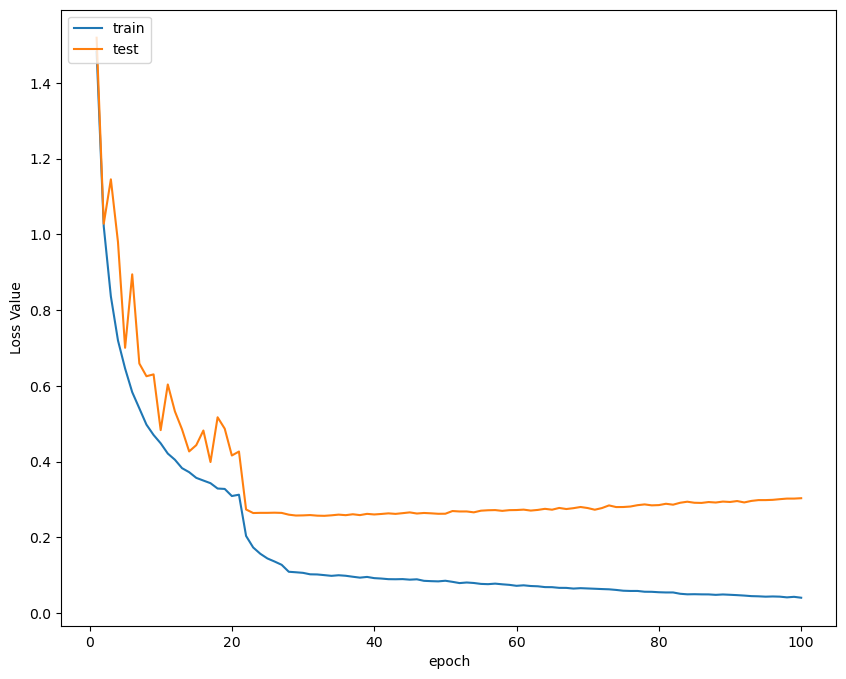

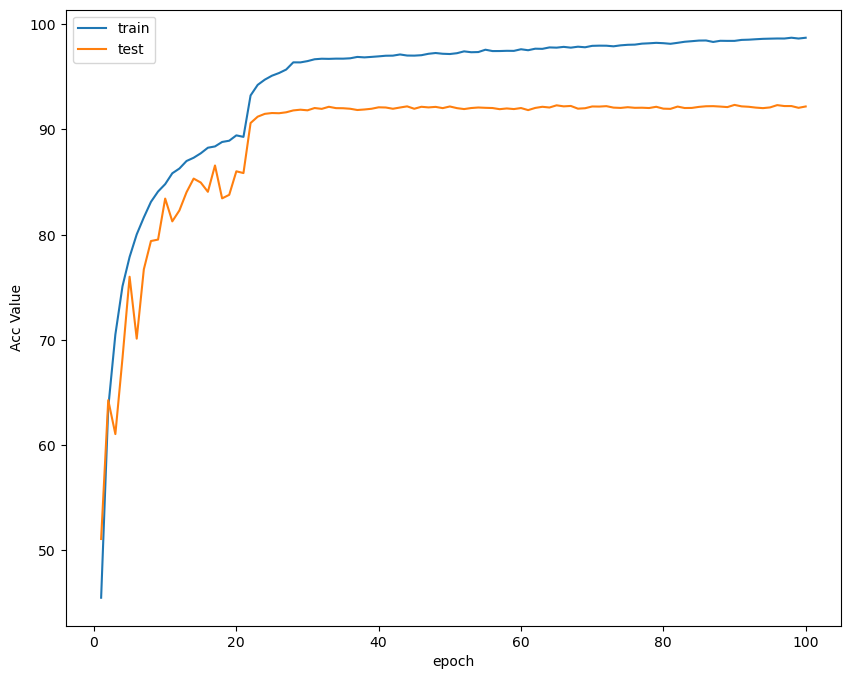

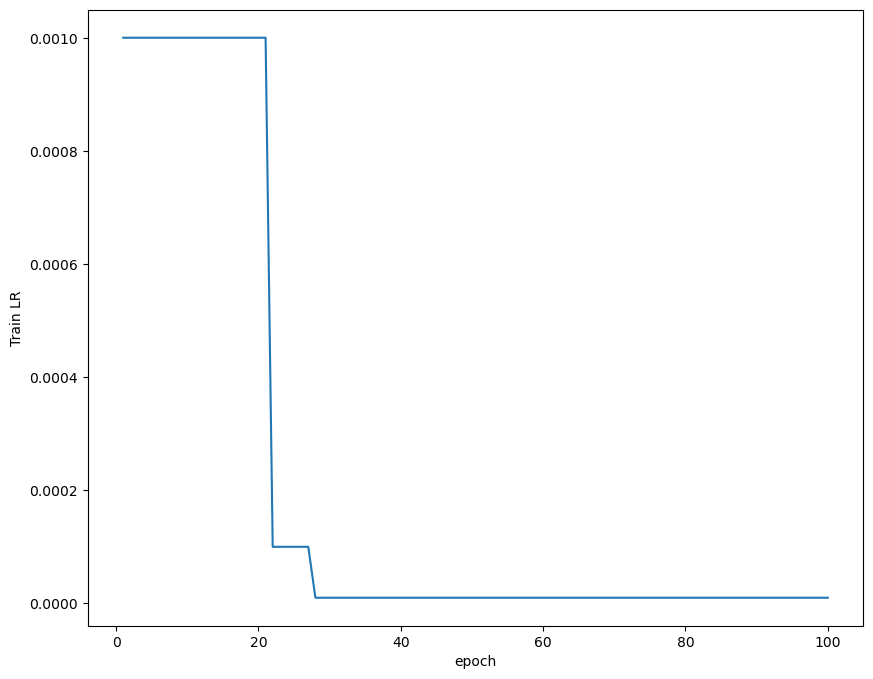

In [13]:
plot_history(epoch ,Acc, Loss, Lr)

## ResNet18 Batch size 256

In [14]:
batch_size = 256

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [16]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [17]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [18]:
Acc, Loss, Lr = train_net(net, trainloader, testloader, epoch, optimizer, criterion, scaler, scheduler)

Epoch [  1/100] | Train Loss:1.507498 | Train Acc:44.47% | Test Loss:1.302404 | Test Acc:54.29% | Learning Rate:0.001000 | Time: 00:28
Epoch [  2/100] | Train Loss:1.052558 | Train Acc:62.22% | Test Loss:1.112896 | Test Acc:62.50% | Learning Rate:0.001000 | Time: 00:29
Epoch [  3/100] | Train Loss:0.842166 | Train Acc:70.38% | Test Loss:1.007730 | Test Acc:65.38% | Learning Rate:0.001000 | Time: 00:29
Epoch [  4/100] | Train Loss:0.712158 | Train Acc:75.36% | Test Loss:0.780803 | Test Acc:73.54% | Learning Rate:0.001000 | Time: 00:30
Epoch [  5/100] | Train Loss:0.631965 | Train Acc:78.17% | Test Loss:0.818027 | Test Acc:73.39% | Learning Rate:0.001000 | Time: 00:29
Epoch [  6/100] | Train Loss:0.573194 | Train Acc:80.17% | Test Loss:0.827294 | Test Acc:72.61% | Learning Rate:0.001000 | Time: 00:30
Epoch [  7/100] | Train Loss:0.526793 | Train Acc:82.14% | Test Loss:0.725038 | Test Acc:76.68% | Learning Rate:0.001000 | Time: 00:30
Epoch [  8/100] | Train Loss:0.488974 | Train Acc:83.42

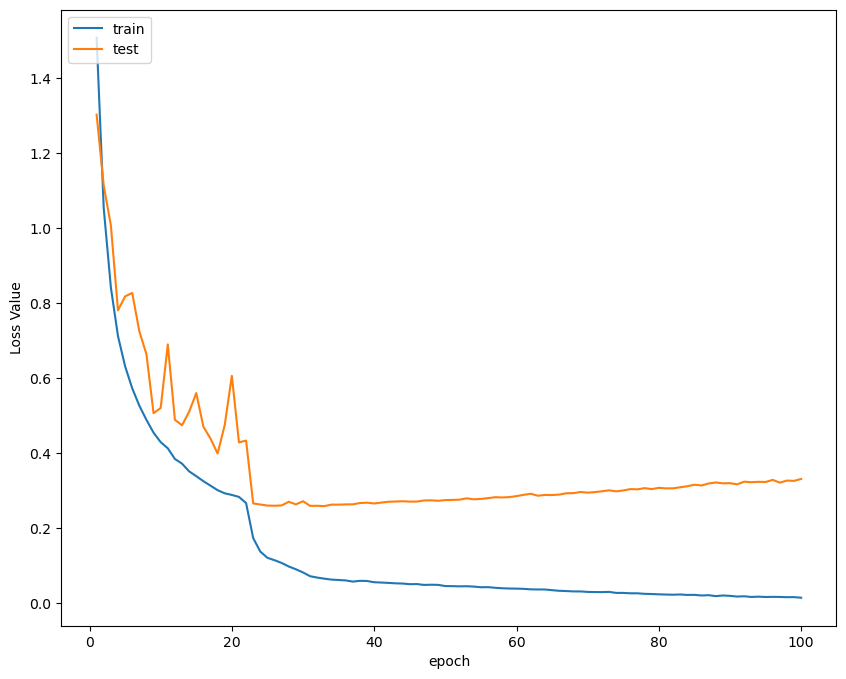

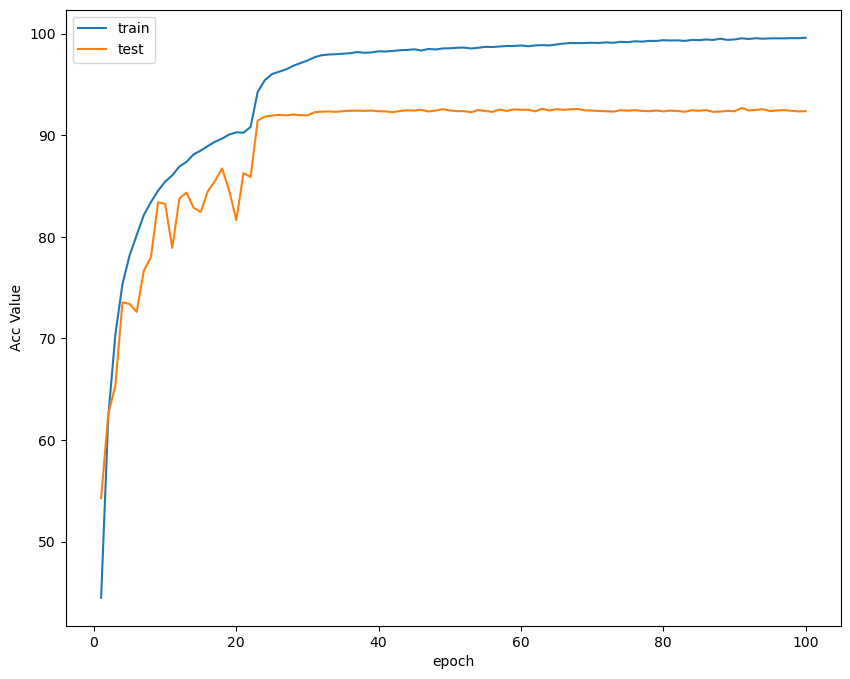

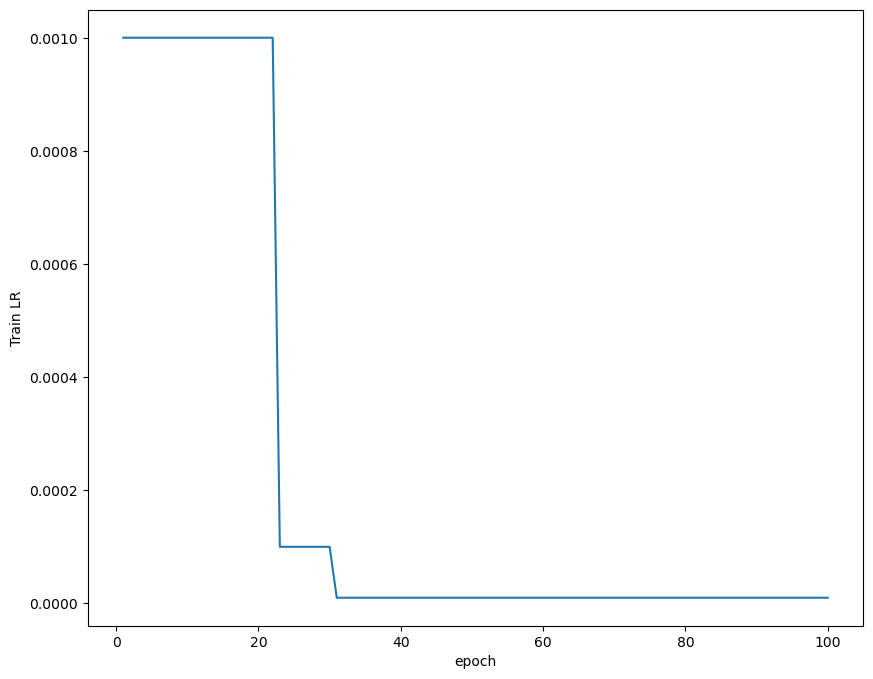

In [19]:
plot_history(epoch, Acc, Loss, Lr)

## ResNet18 Batch size 512

In [20]:
batch_size = 512

In [21]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [22]:
net = ResNet18().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [23]:
epoch = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-5) 

In [24]:
Acc, Loss, Lr = train_net(net, trainloader, testloader, epoch, optimizer, criterion, scaler, scheduler)

Epoch [  1/100] | Train Loss:1.606404 | Train Acc:40.86% | Test Loss:1.618385 | Test Acc:45.16% | Learning Rate:0.001000 | Time: 00:29
Epoch [  2/100] | Train Loss:1.118416 | Train Acc:59.66% | Test Loss:1.175484 | Test Acc:59.62% | Learning Rate:0.001000 | Time: 00:27
Epoch [  3/100] | Train Loss:0.900424 | Train Acc:67.98% | Test Loss:1.081078 | Test Acc:63.33% | Learning Rate:0.001000 | Time: 00:29
Epoch [  4/100] | Train Loss:0.766823 | Train Acc:72.71% | Test Loss:1.004982 | Test Acc:67.38% | Learning Rate:0.001000 | Time: 00:27
Epoch [  5/100] | Train Loss:0.660170 | Train Acc:76.95% | Test Loss:0.808695 | Test Acc:72.26% | Learning Rate:0.001000 | Time: 00:27
Epoch [  6/100] | Train Loss:0.596720 | Train Acc:79.33% | Test Loss:0.858952 | Test Acc:71.75% | Learning Rate:0.001000 | Time: 00:27
Epoch [  7/100] | Train Loss:0.539834 | Train Acc:81.47% | Test Loss:0.664348 | Test Acc:77.19% | Learning Rate:0.001000 | Time: 00:26
Epoch [  8/100] | Train Loss:0.492539 | Train Acc:82.89

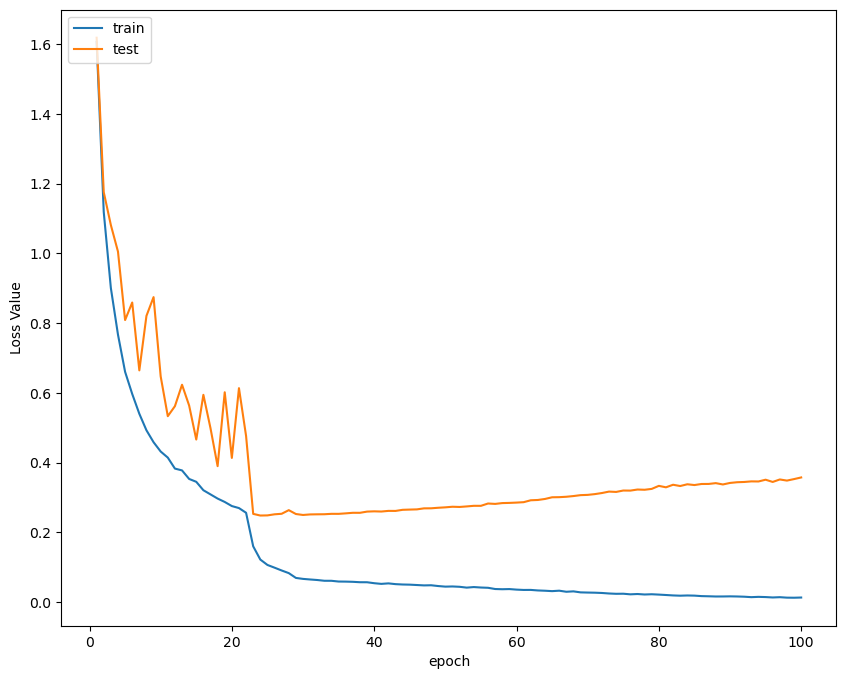

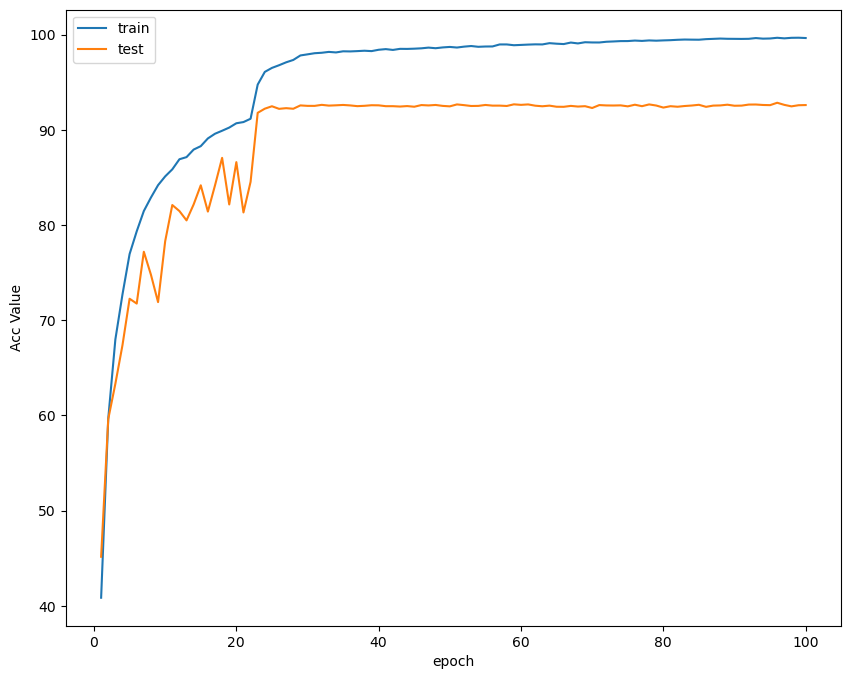

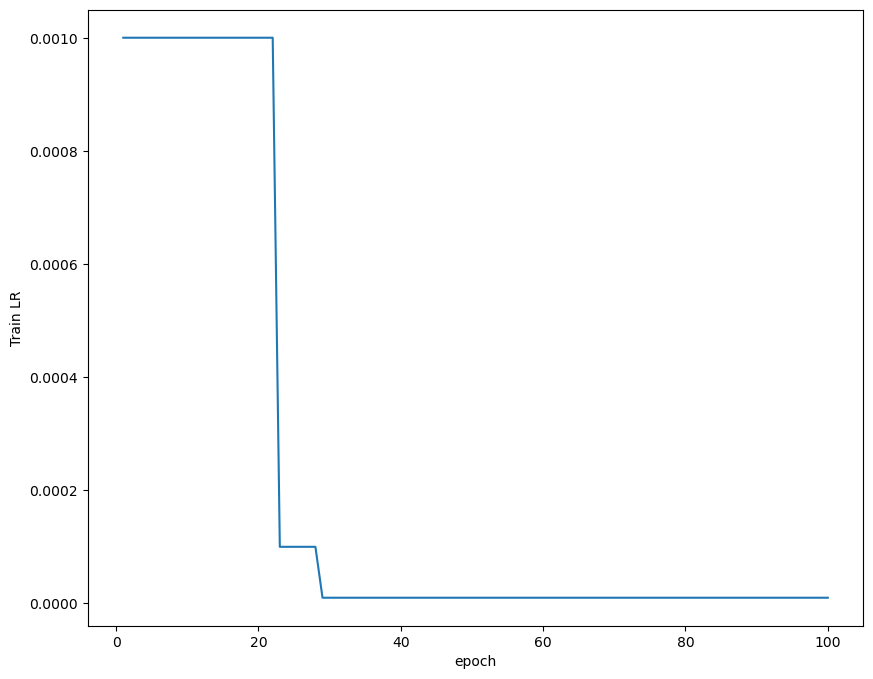

In [25]:
plot_history(epoch, Acc, Loss, Lr)